![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)

<p style="font-size:20px;font-weight: bold;color:blue">ESIEE, filière "Datascience et intelligence artificielle" </p>
<p style="font-size:15px;font-weight: bold;color:blue">DSIA-5101A - Big Data Analytics with Spark (Autumn 2019) -- Instructors: F. Sarradin, B. Men</p>

**Sources**: These labs synthetize and *builds on* labs from several origins: 
- The series of moocs from Berkeley and Databricks,(Creative Commons licences), namely
   - [Introduction to Apache Spark](https://courses.edx.org/courses/course-v1:BerkeleyX+CS105x+1T2016/info)
   - [Big data Analysis with Apache Spark](https://courses.edx.org/courses/course-v1:BerkeleyX+CS110x+2T2016/info)
   - [Distributed Machine Learning with Apache Spark](https://courses.edx.org/courses/course-v1:BerkeleyX+CS120x+2T2016/info)
   - [Introduction to Big Data with Apache Spark](https://courses.edx.org/courses/BerkeleyX/CS100.1x/1T2015/info)
   - [Scalable Machine Learning](https://courses.edx.org/courses/BerkeleyX/CS190.1x/1T2015/info)
- [Apache Spark & Python (pySpark) tutorials for Big Data Analysis and Machine Learning](https://github.com/jadianes/spark-py-notebooks) (Apache License, Version 2.0)

We have kept the labs text in english. This will enable us to reuse them in international sections. 

<p style="font-size:35px;font-weight: bold;">Lab 2 : Web Server Log Analysis with Apache Spark</p>

This lab will demonstrate how easy it is to perform web server log analysis with Apache Spark.

 
Server log analysis is an ideal use case for Spark.  It's a very large, common data source and contains a rich set of information.  Spark allows you to store your logs in files on disk cheaply, while still providing a quick and simple way to perform data analysis on them.  This homework will show you how to use Apache Spark on real-world text-based production logs and fully harness the power of that data.  Log data comes from many sources, such as web, file, and compute servers, application logs, user-generated content,  and can be used for monitoring servers, improving business and customer intelligence, building recommendation systems, fraud detection, and much more.


<p style="font-size:20pt; font-weight: bold;color:blue"> How to complete this lab :</p>

 This assignment is broken up into sections with bite-sized examples for demonstrating Spark functionality for log processing. For each problem, you should start by thinking about the algorithm that you will use to *efficiently* process the log in a parallel, distributed manner. This means using the various [RDD](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) operations along with [`lambda` functions](https://docs.python.org/2/tutorial/controlflow.html#lambda-expressions) that are applied at each worker.

 
This assignment consists of 4 parts:

- Part 1 : Apache Web Server Log file format
- Part 2 : Sample Analyses on the Web Server Log File with Spark Core
- Part 3 : Analyzing Web Server Log File with Spark SQL
- Part 4 : Exploring 404 Response Codes



##  Prerequisites : Spark Context configuration 

<p>If you can't succeed to create SparContext and SQLContext objects such as explained on ESIEE icampus :<br/>
Remove the following comments and modify the "spark_path" variable according to your spark location path.</p>

In [1]:
import os
import sys
# spark_path = "/opt/spark-2.2.0-bin-hadoop2.7/"
# python_path = sys.executable
# os.environ["SPARK_HOME"] = spark_path
# os.environ["HADOOP_HOME"] = spark_path
# os.environ["PYSPARK_PYTHON"] = python_path
# os.environ["PYSPARK_DRIVER_PYTHON"] = python_path
# sys.path.append(spark_path + "python/lib/pyspark.zip")
# sys.path.append(spark_path + "python/lib/py4j-0.10.4-src.zip")
# 
from pyspark import SparkConf, SparkContext, SQLContext
conf = SparkConf().set("master", "local[*]").set("spark.app.name", "ESIEE")
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

# Part 1 : Apache Web Server Log file format

If you're familiar with web servers at all, you'll recognize that this is in [Common Log Format](https://www.w3.org/Daemon/User/Config/Logging.html#common-logfile-format). The fields are:

_remotehost rfc931 authuser [date] "request" status bytes_

| field         | meaning                                                                |
| ------------- | ---------------------------------------------------------------------- |
| _remotehost_  | Remote hostname (or IP number if DNS hostname is not available).       |
| _rfc931_      | The remote logname of the user. We don't really care about this field. |
| _authuser_    | The username of the remote user, as authenticated by the HTTP server.  |
| _[date]_      | The date and time of the request.                                      |
| _"request"_   | The request, exactly as it came from the browser or client.            |
| _status_      | The HTTP status code the server sent back to the client.               |
| _bytes_       | The number of bytes (`Content-Length`) transferred to the client.      |



The log file entries produced in CLF will look something like this:

`127.0.0.1 - - [01/Aug/1995:00:00:01 -0400] "GET /images/launch-logo.gif HTTP/1.0" 200 1839`
 
Each part of this log entry is described below.

* `127.0.0.1`
This is the IP address (or host name, if available) of the client (remote host) which made the request to the server.

 
* `-`
The "hyphen" in the output indicates that the requested piece of information (user identity from remote machine) is not available.

 
* `-`
The "hyphen" in the output indicates that the requested piece of information (user identity from local logon) is not available.

 
* `[01/Aug/1995:00:00:01 -0400]`
The time that the server finished processing the request. The format is:

`[day/month/year:hour:minute:second timezone]`
  * day = 2 digits
  * month = 3 letters
  * year = 4 digits
  * hour = 2 digits
  * minute = 2 digits
  * second = 2 digits
  * zone = (\+ | \-) 4 digits
 
* `"GET /images/launch-logo.gif HTTP/1.0"`
This is the first line of the request string from the client. It consists of a three components: the request method (e.g., `GET`, `POST`, etc.), the endpoint (a [Uniform Resource Identifier](http://en.wikipedia.org/wiki/Uniform_resource_identifier)), and the client protocol version.

 
* `200`
This is the status code that the server sends back to the client. This information is very valuable, because it reveals whether the request resulted in a successful response (codes beginning in 2), a redirection (codes beginning in 3), an error caused by the client (codes beginning in 4), or an error in the server (codes beginning in 5). The full list of possible status codes can be found in the HTTP specification ([RFC 2616](https://www.ietf.org/rfc/rfc2616.txt) section 10).

 
* `1839`
The last entry indicates the size of the object returned to the client, not including the response headers. If no content was returned to the client, this value will be "-" (or sometimes 0).

 
Note that log files contain information supplied directly by the client, without escaping. Therefore, it is possible for malicious clients to insert control-characters in the log files, *so care must be taken in dealing with raw logs.*

 
## NASA-HTTP Web Server Log
For this assignment, we will use a data set from NASA Kennedy Space Center WWW server in Florida. The full data set is freely available (http://ita.ee.lbl.gov/html/contrib/NASA-HTTP.html) and contains two month's of all HTTP requests. We are using a subset that only contains several days worth of requests.



## 1. Parsing Each Log Line
Using the CLF as defined above, we create a regular expression pattern to extract the nine fields of the log line using the Python regular expression [`search` function](https://docs.python.org/2/library/re.html#regular-expression-objects). The function returns a pair consisting of a Row object and 1. If the log line fails to match the regular expression, the function returns a pair consisting of the log line string and 0. A '-' value in the content size field is cleaned up by substituting it with 0. The function converts the log line's date string into a Python `datetime` object using the given `parse_apache_time` function.


In [2]:
import re
import datetime

from pyspark.sql import Row

month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
    'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

def parse_apache_time(s):
    """ Convert Apache time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format
    Returns:
        datetime: datetime object (ignore timezone for now)
    """
    return datetime.datetime(int(s[7:11]),
                             month_map[s[3:6]],
                             int(s[0:2]),
                             int(s[12:14]),
                             int(s[15:17]),
                             int(s[18:20]))


def parseApacheLogLine(logline):
    """ Parse a line in the Apache Common Log format
    Args:
        logline (str): a line of text in the Apache Common Log format
    Returns:
        tuple: either a dictionary containing the parts of the Apache Access Log and 1,
               or the original invalid log line and 0
    """
    match = re.search(APACHE_ACCESS_LOG_PATTERN, logline)
    if match is None:
        return (logline, 0)
    size_field = match.group(9)
    if size_field == '-':
        size = 0
    else:
        size = match.group(9)
    return (Row(
        host          = match.group(1),
        client_identd = match.group(2),
        user_id       = match.group(3),
        date_time     = parse_apache_time(match.group(4)),
        method        = match.group(5),
        endpoint      = match.group(6),
        protocol      = match.group(7),
        response_code = int(match.group(8)),
        content_size  = int(size)
    ), 1)

In [3]:
# A regular expression pattern to extract fields from the log line
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+) (\S+)\s*(\S*)\s*" (\d{3}) (\S+)'

## 2. Configuration and Initial RDD Creation
We are ready to specify the input log file and create an RDD containing the parsed log file data. The log file has already been downloaded for you.

 
To create the primary RDD that we'll use in the rest of this assignment, we first load the text file using [`sc.textfile(logFile)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext.textFile) to convert each line of the file into an element in an RDD.

Next, we use [`map(parseApacheLogLine)`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.map) to apply the parse function to each element (that is, a line from the log file) in the RDD and turn each line into a pair [`Row` object](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Row).

Finally, we cache the RDD in memory since we'll use it throughout this notebook.



In [4]:
import sys
import os
from databricks_test_helper import Test

baseDir = os.path.join('..')
inputPath = os.path.join('data', 'apache.access.log.PROJECT')
logFile = os.path.join(baseDir, inputPath)

def parseLogs():
    """ Read and parse log file """
    parsed_logs = (sc
                   .textFile(logFile)
                   .map(parseApacheLogLine)
                   .cache())

    access_logs = (parsed_logs
                   .filter(lambda s: s[1] == 1)
                   .map(lambda s: s[0])
                   .cache())

    failed_logs = (parsed_logs
                   .filter(lambda s: s[1] == 0)
                   .map(lambda s: s[0]))
    failed_logs_count = failed_logs.count()
    if failed_logs_count > 0:
        print('Number of invalid logline: %d' % failed_logs.count())
        for line in failed_logs.take(20):
            print('Invalid logline: %s' % line)

    print('Read %d lines, successfully parsed %d lines, failed to parse %d lines' % (parsed_logs.count(), access_logs.count(), failed_logs.count()))
    return parsed_logs, access_logs, failed_logs


parsed_logs, access_logs, failed_logs = parseLogs()

Read 1043177 lines, successfully parsed 1043177 lines, failed to parse 0 lines


# Part 2 : Sample Analyses on the Web Server Log File with Spark Core
 
Now that we have an RDD containing the log file as a set of Row objects, we can perform various analyses.

 
## 1. Content Size Statistics

 
Let's compute some statistics about the sizes of content being returned by the web server. In particular, we'd like to know what are the average, minimum, and maximum content sizes.

 
We can compute the statistics by applying a `map` to the `access_logs` RDD. The `lambda` function we want for the map is to extract the `content_size` field from the RDD. The map produces a new RDD containing only the `content_sizes` (one element for each Row object in the `access_logs` RDD). To compute the minimum and maximum statistics, we can use [`min()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.min) and [`max()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.max) functions on the new RDD. We can compute the average statistic by using the [`reduce`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduce) function with a `lambda` function that sums the two inputs, which represent two elements from the new RDD that are being reduced together. The result of the `reduce()` is the total content size from the log and it is to be divided by the number of requests as determined using the [`count()`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count) function on the new RDD.



In [5]:
# TODO: Replace <FILL IN> with appropriate code
# Calculate statistics based on the content size
# HINT : RDD has been indexed in function parseApacheLogLine(). 
# You can now access content sizes using attribute .content_size
content_sizes = access_logs.map(lambda log: log.content_size).cache()
content_sizes_mean = content_sizes.mean() #or content_sizes.reduce(lambda a, b : a + b) / content_sizes.count()
content_sizes_min = content_sizes.min()
content_sizes_max = content_sizes.max()
print('Content Size Avg: %i, Min: %i, Max: %s' % (round(content_sizes_mean), content_sizes_min, content_sizes_max))

Content Size Avg: 17532, Min: 0, Max: 3421948


In [6]:
# TEST Content size statistics
Test.assertEquals((round(content_sizes_mean), content_sizes_min, content_sizes_max), (17532, 0, 3421948), 'incorrect expected values')

1 test passed.


## 2. Response Code Analysis

Next, lets make a count of the response codes that appear in the logs. As with the content size analysis, first we create a new RDD by using a `lambda` function to extract the `response_code` field from the `access_logs` RDD. The difference here is that we will use a [pair tuple](https://docs.python.org/2/tutorial/datastructures.html?highlight=tuple#tuples-and-sequences) instead of just the field itself. Using a pair tuple consisting of the response code and 1 will let us count how many records have a particular response code. Using the new RDD, we perform a [`reduceByKey`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.reduceByKey) function. `reduceByKey` performs a reduce on a per-key basis by applying the `lambda` function to each element, pairwise with the same key. We use the simple `lambda` function of adding the two values. Then, we cache the resulting RDD and create a list by using the [`take`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) function.

_Note_ : The expected method is similar of the word count approach developed in last week TP.

In [7]:
# TODO: Replace <FILL IN> with appropriate code
# Make a Response Code repartition count.
# HINT : you can access to the log response_code using attribute ".response_code".

responseCodeToCount = (access_logs.map(lambda log: (log.response_code, 1))
                       .reduceByKey(lambda x, y : x + y)
                       .cache())
responseCodeToCountList = responseCodeToCount.collect()
print('Found %d response codes' % len(responseCodeToCountList))
print('Response Code Counts: %s' % responseCodeToCountList)

Found 7 response codes
Response Code Counts: [(200, 940847), (304, 79824), (404, 6185), (500, 2), (501, 17), (302, 16244), (403, 58)]


In [8]:
# TEST : Response Code Analysis
Test.assertEquals(sorted(responseCodeToCountList), [(200, 940847), (302, 16244), (304, 79824), (403, 58), (404, 6185), (500, 2), (501, 17)], "Incorrect response code analysis")

1 test passed.


## 3. Response Code Graphing with `matplotlib`
Now, lets visualize the results from the last example. We can visualize the results from the last example using [`matplotlib`](http://matplotlib.org/). First we need to extract the labels and fractions for the graph. We do this with two separate `map` functions with a `lambda` functions. The first `map` function extracts a list of of the response code values, and the second `map` function extracts a list of the per response code counts  divided by the total size of the access logs. Next, we create a figure with `figure()` constructor and use the `pie()` method to create the pie plot.

In [9]:
# TODO: Replace <FILL IN> with appropriate code
# Assign the response code labels using .map() and .collect() to "labels" variable.
# Assign the number of rows to variable "rows_count" (don't forget to collect).
# Assign the proportional count to variable "fracs_count" (don't forget to collect).
labels = responseCodeToCount.map(lambda pair: pair[0]).collect()
rows_count = access_logs.count()
fracs_count = responseCodeToCount.map(lambda pair: pair[1] / rows_count).collect()
print(labels)
print(fracs_count)

[200, 304, 404, 500, 501, 302, 403]
[0.9019054292799784, 0.07652009198822443, 0.005929003419362198, 1.9172201841106543e-06, 1.629637156494056e-05, 0.015571662335346735, 5.5599385339208974e-05]


In [10]:
# TEST : Response code graphing
Test.assertEquals(sorted(fracs_count), [1.9172201841106543e-06, 1.629637156494056e-05, 5.5599385339208974e-05, 0.005929003419362198, 0.015571662335346735, 0.07652009198822443, 0.9019054292799784], "Incorrect proportions")

1 test passed.


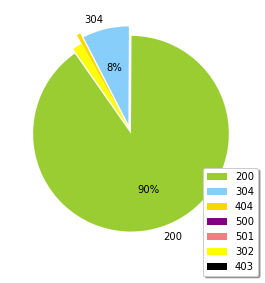

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline


def pie_pct_format(value):
    """ Determine the appropriate format string for the pie chart percentage label
    Args:
        value: value of the pie slice
    Returns:
        str: formated string label; if the slice is too small to fit, returns an empty string for label
    """
    return '' if value < 7 else '%.0f%%' % value

fig = plt.figure(figsize=(4.5, 4.5), facecolor='white', edgecolor='white')
colors = ['yellowgreen', 'lightskyblue', 'gold', 'purple', 'lightcoral', 'yellow', 'black']
explode = (0.05, 0.05, 0.1, 0, 0, 0, 0)
patches, texts, autotexts = plt.pie(fracs_count, labels=labels, colors=colors,
                                    explode=explode, autopct=pie_pct_format,
                                    shadow=False,  startangle=125)
for text, autotext in zip(texts, autotexts):
    if autotext.get_text() == '':
        text.set_text('')  # If the slice is small to fit, don't show a text label
plt.legend(labels, loc=(0.80, -0.1), shadow=True)
pass

## 4. Visualizing Endpoints

Now, lets visualize the number of hits to endpoints (URIs) in the log. To do that, perform a endpoints counts similar to response codes approach.

_Hint_ : To perform this task, we first create a new RDD by using a `lambda` function to extract the `endpoint` field from the `access_logs` RDD using a pair tuple consisting of the endpoint and 1 which will let us count how many records were created by a particular host's request. Using the new RDD, we perform a `reduceByKey` function with a `lambda` function that adds the two values. We then cache the results.

 
Next we visualize the results using `matplotlib`. We previously imported the `matplotlib.pyplot` library, so we do not need to import it again. We perform two separate `map` functions with `lambda` functions. The first `map` function extracts a list of endpoint values, and the second `map` function extracts a list of the visits per endpoint values. Next, we create a figure with `figure()` constructor, set various features of the plot (axis limits, grid lines, and labels), and use the `plot()` method to create the line plot.



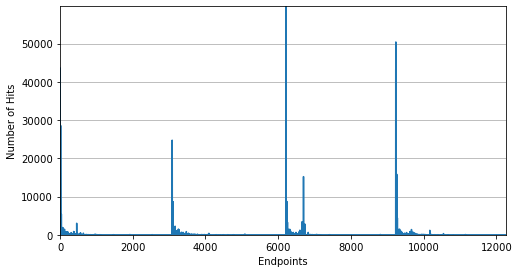

In [12]:
# TODO: Replace <FILL IN> with appropriate code
# Assign the endpoints <key, value> counts to variable "endpoints" using .map() and .reduceByKey().
# Assign the endpoints labels to variable "ends_labels" (don't forget to collect).
# Assign the count to variables "end_counts" (don't forget to collect).
endpoints = access_logs.map(lambda log: (log.endpoint, 1)).reduceByKey(lambda x, y : x + y).cache()
ends_labels = endpoints.map(lambda pair: pair[0]).collect()
ends_counts = endpoints.map(lambda pair: pair[1]).collect()

fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, len(ends_labels), 0, max(ends_counts)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Endpoints')
plt.ylabel('Number of Hits')
plt.plot(ends_counts)
pass

## 5. Top 10 transferred bytes hosts

Now, let's answer the following question. Who are the top 10 hosts in terms of transferred bytes (content size) ? 

To perform this task, use RDD transformations `map`, `reduceByKey` and [`takeOrdered`](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.takeOrdered).

In [13]:
# TODO: Replace <FILL IN> with appropriate code
# Assign the top 10 hosts considering transfered bytes to the variable "top_10_hosts".
top_10_hosts_and_bytes = access_logs.map(lambda log: (log.host, log.content_size)).reduceByKey(lambda x, y: x + y).takeOrdered(10, lambda x: - x[1])
#or top_10_hosts_and_bytes = access_logs.map(lambda row: (row["host"], row["content_size"])).reduceByKey(lambda a, b: a + b).takeOrdered(10, lambda x: - x[1])
top_10_hosts = [host[0] for host in top_10_hosts_and_bytes]
print(top_10_hosts)

['news.ti.com', 'www-relay.pa-x.dec.com', 'piweba5y.prodigy.com', 'e659229.boeing.com', 'piweba3y.prodigy.com', 'www-c2.proxy.aol.com', '163.206.89.4', 'www-b3.proxy.aol.com', 'webgate1.mot.com', 'gatekeeper.cca.rockwell.com']


In [14]:
# TEST : Top 10 tranfered bytes hosts
Test.assertEquals(len(top_10_hosts), 10, "top_10_hosts had to be length 10")
Test.assertEquals(top_10_hosts, ['news.ti.com', 'www-relay.pa-x.dec.com', 'piweba5y.prodigy.com', 'e659229.boeing.com', 'piweba3y.prodigy.com', 'www-c2.proxy.aol.com', '163.206.89.4', 'www-b3.proxy.aol.com', 'webgate1.mot.com', 'gatekeeper.cca.rockwell.com'], "Incorrect top 10 hosts")

1 test passed.
1 test passed.


# Part 3 : Analyzing Web Server Log File with Spark SQL
 
Now it is time to perform advanced analytics on web server log files using Spark SQL.



## 1. Transform Spark RDD to Spark SQL dataframe

In order to use Spark SQL functionalities, you need to transform your logs data spark RDD to a Spark SQL dataframe. To perform this task, you can refer to the Spark lectures provided in classroom or spark documentation. After dataframe load, make sure that dataframe column casting is correct using method `printSchema`.

In [15]:
# TODO: Replace <FILL IN> with appropriate code
# Transform the access_logs spark RDD into Spark SQL Dataframe.
# Hint : Use the sqlContext and the .createDataFrame() method.
logs_df = sqlContext.createDataFrame(access_logs)
logs_df = logs_df.cache()
logs_df.printSchema()

root
 |-- client_identd: string (nullable = true)
 |-- content_size: long (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- endpoint: string (nullable = true)
 |-- host: string (nullable = true)
 |-- method: string (nullable = true)
 |-- protocol: string (nullable = true)
 |-- response_code: long (nullable = true)
 |-- user_id: string (nullable = true)



In [16]:
# TEST : Transform Spark RDD to Spark SQL dataframe
Test.assertEquals(str(type(logs_df)), "<class 'pyspark.sql.dataframe.DataFrame'>", "logs_df is not a Spark DataFrame.")
Test.assertEquals(logs_df.dtypes, [('client_identd', 'string'), ('content_size', 'bigint'), ('date_time', 'timestamp'), ('endpoint', 'string'), ('host', 'string'), ('method', 'string'), ('protocol', 'string'), ('response_code', 'bigint'), ('user_id', 'string')], "Dataframe casting is not correct.")

1 test passed.
1 test passed.


## 2. Top 10 error endpoints

What are the top twenty paths which did not have return code 200? Create a sorted list containing the paths and the number of times that they were accessed with a non-200 return code and show the top ten.

Think about the steps that you need to perform to determine which paths did not have a 200 return code, how you will uniquely count those paths and sort the list.

In [17]:
# TODO: Replace <FILL IN> with appropriate code
# Assign logs with status different than 200 to variable "not200_df".
# Assign the counts per endpoint dataframe to variable "logs_sums_df". 
# Descending sort the logs_sum_df and assign the result to variable "sorted_logs_sum_df".
# Collect the top 10 endpoints and assign it to variable "top_ten_err_urls".
# Hint : You will need to use methods .groupBy() and .sort() to achieve this task.
# Note : You are welcome to structure your solution in a different way, so long as
# you ensure the variables used in the next Test section are defined (ie. logs_sum_df, top_ten_err_urls).

not200_df = logs_df.filter(logs_df['response_code'] != '200')
logs_sum_df = not200_df.groupBy('endpoint').count()
sorted_logs_sum_df = logs_sum_df.sort('count', ascending=False)
top_ten_err_urls = sorted_logs_sum_df.take(10)

# Display
print('Top Ten failed URLs:')
sorted_logs_sum_df.show(10, False)
print(top_ten_err_urls)

Top Ten failed URLs:
+---------------------------------------+-----+
|endpoint                               |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |8761 |
|/images/KSC-logosmall.gif              |7236 |
|/images/MOSAIC-logosmall.gif           |5197 |
|/images/USA-logosmall.gif              |5157 |
|/images/WORLD-logosmall.gif            |5020 |
|/images/ksclogo-medium.gif             |4728 |
|/history/apollo/images/apollo-logo1.gif|2907 |
|/images/launch-logo.gif                |2811 |
|/                                      |2199 |
|/images/ksclogosmall.gif               |1622 |
+---------------------------------------+-----+
only showing top 10 rows

[Row(endpoint='/images/NASA-logosmall.gif', count=8761), Row(endpoint='/images/KSC-logosmall.gif', count=7236), Row(endpoint='/images/MOSAIC-logosmall.gif', count=5197), Row(endpoint='/images/USA-logosmall.gif', count=5157), Row(endpoint='/images/WORLD-logosmall.gif', count=5020),

In [18]:
# TEST Top ten error endpoints
Test.assertEquals(logs_sum_df.count(), 7689, 'incorrect count for endpointSum')
Test.assertEquals(top_ten_err_urls, [(u'/images/NASA-logosmall.gif', 8761), (u'/images/KSC-logosmall.gif', 7236), (u'/images/MOSAIC-logosmall.gif', 5197), (u'/images/USA-logosmall.gif', 5157), (u'/images/WORLD-logosmall.gif', 5020), (u'/images/ksclogo-medium.gif', 4728), (u'/history/apollo/images/apollo-logo1.gif', 2907), (u'/images/launch-logo.gif', 2811), (u'/', 2199), (u'/images/ksclogosmall.gif', 1622)], 'incorrect Top Ten failed URLs (topTenErrURLs)')

1 test passed.
1 test passed.


## 3. Number of Unique Hosts

How many unique hosts are there in the entire log?

 
Think about the steps that you need to perform to count the number of different hosts in the log.



In [19]:
# TODO: Replace <FILL IN> with appropriate code
# Note : There are several ways to achieve this task.
unique_host_count = logs_df.select('host').distinct().count()
print('Unique hosts: {0}'.format(unique_host_count))

Unique hosts: 54507


In [20]:
# TEST Number of unique hosts
Test.assertEquals(unique_host_count, 54507, 'incorrect unique_host_count')

1 test passed.


## 4. Extract the date day using an UDF

In the next questions, we will compute the number of unique Daily hosts given the day of the month. To perform this following task, we need to create a new column which contains the day of the month (from 01 to 31). Fortunately, the day of the month is contained in the column `date_time` pattern.

_Note_ : There are several ways to achieve this task including using method pyspark sql function `dayofmonth`. In this exercise, we will use a UDF based solution in order to make you practice with the UDF concept. It is strongly recommended for you to look at the UDF slides provided during lecture 3.

_Note_ : Since the log only covers a single month, you can ignore the month.

In [21]:
# TODO: Replace <FILL IN> with appropriate code
# Complete the function 'date_to_day' in order to return the day of the month.
# Wrap the function into and UDF object. Assign the result to variable "my_udf".
# Apply the UDF on logs_df using method .WithColumn(). The resulting column has to be named "day". Assign the resulting
# dataframe to variable "logs_df_with_day".
from pyspark.sql.functions import udf

def date_to_day(date):
    """
    Extracts the day of month in variable date.
    date : timestamp with pattern "yyyy-mm-dd hh:mm:ss"
    returns : day of the month (pattern 'dd')
    """
    str_date = str(date)
    return str_date[8:10]

# testing the function
Test.assertEquals(date_to_day("1995-08-01 00:00:07"), "01", 'function date_to_day is not correct.')
Test.assertEquals(date_to_day("2017-09-17 10:00:07"), "17", 'function date_to_day is not correct.')

# Wrap in a UDF and apply on logs_df
my_udf = udf(lambda col: date_to_day(col))
logs_df_with_day = logs_df.withColumn("day", my_udf("date_time"))
logs_df_with_day.show(5)

1 test passed.
1 test passed.
+-------------+------------+-------------------+--------------------+-----------------+------+--------+-------------+-------+---+
|client_identd|content_size|          date_time|            endpoint|             host|method|protocol|response_code|user_id|day|
+-------------+------------+-------------------+--------------------+-----------------+------+--------+-------------+-------+---+
|            -|        1839|1995-08-01 00:00:01|/shuttle/missions...|in24.inetnebr.com|   GET|HTTP/1.0|          200|      -| 01|
|            -|           0|1995-08-01 00:00:07|                   /|  uplherc.upl.com|   GET|HTTP/1.0|          304|      -| 01|
|            -|           0|1995-08-01 00:00:08|/images/ksclogo-m...|  uplherc.upl.com|   GET|HTTP/1.0|          304|      -| 01|
|            -|           0|1995-08-01 00:00:08|/images/MOSAIC-lo...|  uplherc.upl.com|   GET|HTTP/1.0|          304|      -| 01|
|            -|           0|1995-08-01 00:00:08|/images/USA-

In [22]:
# TEST Extract the month day using an UDF
distinct_days = logs_df_with_day.select("day").distinct().collect()
Test.assertEquals(len(distinct_days), 21, 'it seems that UDF is misapplied')

1 test passed.


## 5. Number of Unique Daily Hosts

For an advanced exercise, let's determine the number of unique hosts in the entire log on a day-by-day basis. This computation will give us counts of the number of unique daily hosts. We'd like a DataFrame sorted by increasing day of the month which includes the day of the month and the associated number of unique hosts for that day. Make sure you cache the resulting DataFrame `daily_hosts_df` so that we can reuse it in the next exercise.

Think about the steps that you need to perform to count the number of different hosts that make requests *each* day.
*Since the log only covers a single month, you can ignore the month.*  You may want to use the `day` column you have computed in the previous task.

In [23]:
# TODO: Replace <FILL IN> with appropriate code
# Select columns "day" and "host" from "logs_df_with_day" dataframe and assign the result to "day_to_host_pair_df".
# Remove duplicates <"day", "host"> duplicates using method .distinct(). Assign the result to day_group_hosts_df.
# Group by day and count the distinct hosts. Assign the result dataframe to "daily_hosts_df".
# Sort per day and assign the result to "daily_hosts_df_sorted".
# Collect the result to driver. Assign the result to variable "daily_hosts_list".

day_to_host_pair_df = logs_df_with_day.select("day", "host")
day_group_hosts_df = day_to_host_pair_df.distinct()
daily_hosts_df = day_group_hosts_df.select("day").groupBy('day').count().cache()
daily_hosts_df_sorted = daily_hosts_df.sort("day")
daily_hosts_list = daily_hosts_df_sorted.collect()

print('Unique hosts per day:')
daily_hosts_df_sorted.show(30, False)
daily_hosts_df = daily_hosts_df.cache()

Unique hosts per day:
+---+-----+
|day|count|
+---+-----+
|01 |2582 |
|03 |3222 |
|04 |4190 |
|05 |2502 |
|06 |2537 |
|07 |4106 |
|08 |4406 |
|09 |4317 |
|10 |4523 |
|11 |4346 |
|12 |2864 |
|13 |2650 |
|14 |4454 |
|15 |4214 |
|16 |4340 |
|17 |4385 |
|18 |4168 |
|19 |2550 |
|20 |2560 |
|21 |4134 |
|22 |4456 |
+---+-----+



In [24]:
# TEST Number of unique daily hosts (3c)
Test.assertEquals(daily_hosts_df.count(), 21, 'incorrect dailyHosts.count()')
Test.assertEquals(daily_hosts_list, [("01", 2582), ("03", 3222), ("04", 4190), ("05", 2502), ("06", 2537), ("07", 4106), ("08", 4406), ("09", 4317), ("10", 4523), ("11", 4346), ("12", 2864), ("13", 2650), ("14", 4454), ("15", 4214), ("16", 4340), ("17", 4385), ("18", 4168), ("19", 2550), ("20", 2560), ("21", 4134), ("22", 4456)], 'incorrect dailyHostsList')
Test.assertTrue(daily_hosts_df.is_cached, 'incorrect dailyHosts.is_cached')

1 test passed.
1 test passed.
1 test passed.


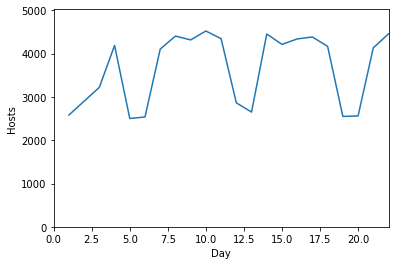

In [25]:
# plotting your results : 
days = [int(element[0]) for element in daily_hosts_list]
hosts = [int(element[1]) for element in daily_hosts_list]
plt.plot(days, hosts)
plt.axis([0, max(days), 0, max(hosts)+500])
plt.xlabel('Day')
plt.ylabel('Hosts')
plt.show()

## 6. Mean Transfered Bytes per status code categories

For an advanced exercise, let's determine the mean transfered bytes per status code category. Remember that :
- Code beginning with a `2` means a request resulted in a successful response.
- Code beginning with a `3` means a request resulted in a redirection.
- Code beginning with a `4` means a request resulted in a client error.
- Code beginning with a `5` means a request resulted in a server error.

For every of these four category, compute the mean transfered bytes (content size).

_Hint_ : There are many ways to compute the code category column including the use of an UDF. You can choose the method you prefer. Feel free to refer to spark documentation and StackOverflow posts in order to find functions or informations you are searching for.

In [26]:
# TODO: Replace <FILL IN> with appropriate code
# Add a new colummn to logs_df contaning the code category. Assign the result to 'logs_df_with_code_category'.
# Group the logs per 'code category' computed in first subtask. Assign the result to 'logs_df_groupby_code_category'.
# Compute the content size mean per category and return the result to the driver. Assign the result 
# to 'content_size_per_code_category'.

from pyspark.sql.types import IntegerType

def code_category(response_code):
    code = str(response_code)
    return int(code[0])


code_category_udf = udf(code_category,IntegerType())


logs_df_with_code_category = logs_df.withColumn("code_category",code_category_udf("response_code"))
logs_df_groupby_code_category = logs_df_with_code_category.groupBy("code_category")
logs_df_agg_content_size = logs_df_groupby_code_category.avg("content_size")
content_size_per_code_category = logs_df_agg_content_size.collect()
content_size_per_code_category

[Row(code_category=3, avg(content_size)=14.378398634300703),
 Row(code_category=5, avg(content_size)=10.421052631578947),
 Row(code_category=4, avg(content_size)=0.0),
 Row(code_category=2, avg(content_size)=19436.884191584817)]

In [27]:
round_result = [(el[0], round(el[1], 1)) for el in content_size_per_code_category]
Test.assertEquals(len(content_size_per_code_category), 4, 'error : length has to be 4.')
Test.assertEquals(round_result, [(3, 14.4), (5, 10.4), (4, 0.0), (2, 19436.9)], 'incorrect mean size content per category.')

1 test passed.
1 test passed.


# Part 4 : Exploring 404 Response Codes
 
Let's drill down and explore the error 404 response code records. 404 errors are returned when an endpoint is not found by the server (i.e., a missing page or object). During this part, you are free to complete the tasks using `Spark Core` and `access_logs` RDD or using `Spark SQL` and `logs-df` dataframe.

_Note_ : Do not forget to cache your RDD / Dataframe in memory in order to reduce computing time.

## 1. Counting 404 Response Codes
 
How many 404 records are there in the logs? Assign the result to variable `badRecords`.

In [28]:
# TODO: Replace <FILL IN> with appropriate code

# Spark Core :
badRecords = access_logs.filter(lambda log: log.response_code == 404).cache()
badRecords_count = badRecords.count()
print('Found %d 404 URLs' % badRecords_count)

# Spark SQL :
badRecords = logs_df.filter(logs_df.response_code == 404).cache()
badRecords_count = badRecords.count()
print('Found %d 404 URLs' % badRecords_count)

Found 6185 404 URLs
Found 6185 404 URLs


In [29]:
# TEST Counting 404 (4a)
Test.assertEquals(badRecords_count, 6185, 'incorrect badRecords.count()')

1 test passed.


## 2. Listing The top-15 404 Response Code endpoints

Get the top 15 endpoints that return 404 errors. Assign the result to variable `top_15_404`.

_Note_ : variable `top_15_404` has to be a list only containing top 404 error endpoints.




In [30]:
# TODO: Replace <FILL IN> with appropriate code

# Spark Core :
badRecords = access_logs.filter(lambda log: log.response_code == 404).cache()
top_15_404 = badRecords.map(lambda row: (row["endpoint"], 1)).reduceByKey(lambda a, b: a + b).takeOrdered(15, lambda x: - x[1])
top_15_404 = [element[0] for element in top_15_404]
print('404 Top 15 URLS: %s' % top_15_404)

# Spark SQL : 
badRecords = logs_df.filter(logs_df.response_code == 404).cache()
top_15_404 = badRecords.groupBy("endpoint").count().orderBy("count", ascending=False).take(15)
top_15_404 = [element[0] for element in top_15_404]
print('404 Top 15 URLS: %s' % top_15_404)

404 Top 15 URLS: ['/pub/winvn/readme.txt', '/pub/winvn/release.txt', '/shuttle/missions/STS-69/mission-STS-69.html', '/images/nasa-logo.gif', '/elv/DELTA/uncons.htm', '/shuttle/missions/sts-68/ksc-upclose.gif', '/history/apollo/sa-1/sa-1-patch-small.gif', '/images/crawlerway-logo.gif', '/://spacelink.msfc.nasa.gov', '/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', '/history/apollo/a-001/a-001-patch-small.gif', '/images/Nasa-logo.gif', '/shuttle/resources/orbiters/atlantis.gif', '/history/apollo/images/little-joe.jpg', '/images/lf-logo.gif']
404 Top 15 URLS: ['/pub/winvn/readme.txt', '/pub/winvn/release.txt', '/shuttle/missions/STS-69/mission-STS-69.html', '/images/nasa-logo.gif', '/elv/DELTA/uncons.htm', '/shuttle/missions/sts-68/ksc-upclose.gif', '/history/apollo/sa-1/sa-1-patch-small.gif', '/images/crawlerway-logo.gif', '/://spacelink.msfc.nasa.gov', '/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', '/history/apollo/a-001/a-001-patch-small.gif',

In [31]:
# TEST Listing 404 records (4.2)
Test.assertEquals(len(top_15_404), 15, "top_15_404 length has to be 15.")
Test.assertEquals(top_15_404, ['/pub/winvn/readme.txt', '/pub/winvn/release.txt', '/shuttle/missions/STS-69/mission-STS-69.html', '/images/nasa-logo.gif', '/elv/DELTA/uncons.htm', '/shuttle/missions/sts-68/ksc-upclose.gif', '/history/apollo/sa-1/sa-1-patch-small.gif', '/images/crawlerway-logo.gif', '/://spacelink.msfc.nasa.gov', '/history/apollo/pad-abort-test-1/pad-abort-test-1-patch-small.gif', '/history/apollo/a-001/a-001-patch-small.gif', '/images/Nasa-logo.gif', '/shuttle/resources/orbiters/atlantis.gif', '/history/apollo/images/little-joe.jpg', '/images/lf-logo.gif'], 'top_15_404 not correct')

1 test passed.
1 test passed.


## 3. Listing the Top Twenty-five 404 Response Code Hosts

Instead of looking at the endpoints that generated 404 errors, let's look at the hosts that encountered 404 errors. Using the RDD / Dataframe containing only log records with a 404 response code that you cached in part (4.1), print out a list of the top twenty-five hosts that generate the most 404 errors. Assign the result to variable `errHostsTop25` and return your results to the driver. 



In [32]:
# TODO: Replace <FILL IN> with appropriate code

# Spark Core :
badRecords = access_logs.filter(lambda log: log.response_code == 404).cache()
errHostsCountPairTuple = badRecords.map(lambda log: (log.host, 1))
errHostsSum = errHostsCountPairTuple.reduceByKey(lambda a,b: a+b)
errHostsTop25 = errHostsSum.top(25, lambda s: s[1])

# Spark SQL :
badRecords = logs_df.filter(logs_df.response_code == 404).cache()
errHostsTop25 = badRecords.groupBy("host").count().orderBy("count", ascending=False).take(25)

print('Top 25 hosts that generated errors: %s' % errHostsTop25)

Top 25 hosts that generated errors: [Row(host='piweba3y.prodigy.com', count=39), Row(host='maz3.maz.net', count=39), Row(host='gate.barr.com', count=38), Row(host='nexus.mlckew.edu.au', count=37), Row(host='ts8-1.westwood.ts.ucla.edu', count=37), Row(host='m38-370-9.mit.edu', count=37), Row(host='204.62.245.32', count=33), Row(host='163.206.104.34', count=27), Row(host='spica.sci.isas.ac.jp', count=27), Row(host='www-d4.proxy.aol.com', count=26), Row(host='203.13.168.17', count=25), Row(host='203.13.168.24', count=25), Row(host='www-c4.proxy.aol.com', count=25), Row(host='internet-gw.watson.ibm.com', count=24), Row(host='piweba5y.prodigy.com', count=23), Row(host='scooter.pa-x.dec.com', count=23), Row(host='crl5.crl.com', count=23), Row(host='slip145-189.ut.nl.ibm.net', count=22), Row(host='onramp2-9.onr.com', count=22), Row(host='198.40.25.102.sap2.artic.edu', count=21), Row(host='gn2.getnet.com', count=20), Row(host='msp1-16.nas.mr.net', count=20), Row(host='isou24.vilspa.esa.es', co

In [33]:
# TEST Top twenty-five 404 response code hosts (4.3)
Test.assertEquals(len(errHostsTop25), 25, 'length of errHostsTop25 is not 25')
Test.assertEquals(len(set(errHostsTop25) - set([(u'maz3.maz.net', 39), (u'piweba3y.prodigy.com', 39), (u'gate.barr.com', 38), (u'm38-370-9.mit.edu', 37), (u'ts8-1.westwood.ts.ucla.edu', 37), (u'nexus.mlckew.edu.au', 37), (u'204.62.245.32', 33), (u'163.206.104.34', 27), (u'spica.sci.isas.ac.jp', 27), (u'www-d4.proxy.aol.com', 26), (u'www-c4.proxy.aol.com', 25), (u'203.13.168.24', 25), (u'203.13.168.17', 25), (u'internet-gw.watson.ibm.com', 24), (u'scooter.pa-x.dec.com', 23), (u'crl5.crl.com', 23), (u'piweba5y.prodigy.com', 23), (u'onramp2-9.onr.com', 22), (u'slip145-189.ut.nl.ibm.net', 22), (u'198.40.25.102.sap2.artic.edu', 21), (u'gn2.getnet.com', 20), (u'msp1-16.nas.mr.net', 20), (u'isou24.vilspa.esa.es', 19), (u'dial055.mbnet.mb.ca', 19), (u'tigger.nashscene.com', 19)])), 0, 'incorrect errHostsTop25')

1 test passed.
1 test passed.


## 4. Listing 404 Response Codes per Day

Let's explore the 404 records temporally. Break down the 404 requests by day (`cache()` the RDD `errDateSorted`) and get the daily counts sorted by day as a list. Assign the result to variable `errByDate` and return the result to driver.

*Since the log only covers a single month, you can ignore the month in your checks.*



In [34]:
# TODO: Replace <FILL IN> with appropriate code

# Spark Core :
badRecords = access_logs.filter(lambda log: log.response_code == 404).cache()
errDateCountPairTuple = badRecords.map(lambda log: (log.date_time.day,1))
errDateSum = errDateCountPairTuple.reduceByKey(lambda a,b: a+b)
errDateSorted = (errDateSum.sortByKey()).cache()
errByDate = errDateSorted.collect()

# spark SQL :
badRecords = logs_df.filter(logs_df.response_code == 404).cache()
errByDate = badRecords.withColumn("day", my_udf("date_time")).groupBy("day").count().orderBy("day").collect()
errByDate = [(int(el[0]), int(el[1])) for el in errByDate]
print('404 Errors by day: %s' % errByDate)

404 Errors by day: [(1, 243), (3, 303), (4, 346), (5, 234), (6, 372), (7, 532), (8, 381), (9, 279), (10, 314), (11, 263), (12, 195), (13, 216), (14, 287), (15, 326), (16, 258), (17, 269), (18, 255), (19, 207), (20, 312), (21, 305), (22, 288)]


In [35]:
# TEST 404 response codes per day (4.4)
Test.assertEquals(errByDate, [(1, 243), (3, 303), (4, 346), (5, 234), (6, 372), (7, 532), (8, 381), (9, 279), (10, 314), (11, 263), (12, 195), (13, 216), (14, 287), (15, 326), (16, 258), (17, 269), (18, 255), (19, 207), (20, 312), (21, 305), (22, 288)], 'incorrect errByDate')

1 test passed.


## 5. Visualizing the 404 Response Codes by Day

Using the results from the previous exercise, use `matplotlib` to plot a "Line" or "Bar" graph of the 404 response codes by day.

In [36]:
# TODO: Replace <FILL IN> with appropriate code
daysWithErrors404 = [el[0] for el in errByDate]
errors404ByDay = [el[1] for el in errByDate]

In [37]:
# TEST Visualizing the 404 Response Codes by Day (4f)
Test.assertEquals(daysWithErrors404, [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'incorrect daysWithErrors404')
Test.assertEquals(errors404ByDay, [243, 303, 346, 234, 372, 532, 381, 279, 314, 263, 195, 216, 287, 326, 258, 269, 255, 207, 312, 305, 288], 'incorrect errors404ByDay')

1 test passed.
1 test passed.


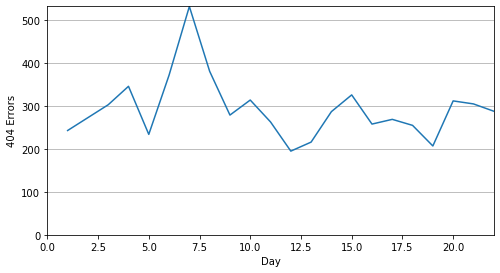

In [38]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(daysWithErrors404), 0, max(errors404ByDay)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Day')
plt.ylabel('404 Errors')
plt.plot(daysWithErrors404, errors404ByDay)
pass

## 6. Hourly 404 Response Codes

Using the RDD / Dataframe `badRecords` you cached in the part (4.1) and by hour of the day and in increasing order, create an RDD / Dataframe containing how many requests had a 404 return code for each hour of the day (midnight starts at 0). Cache the resulting RDD hourRecordsSorted. Assign the result to variable `errHourList`and don't forget to return the result to the driver.

_Hint_ : Concerning the Spark SQL approach, multiple methods exist including the use of an UDF similar to exercise (3.4).

In [39]:
# TODO: Replace <FILL IN> with appropriate code
# Spark Core :
badRecords = access_logs.filter(lambda log: log.response_code == 404).cache()
hourCountPairTuple = badRecords.map(lambda log: (log.date_time.hour,1))
hourRecordsSum = hourCountPairTuple.reduceByKey(lambda a,b: a+b)
hourRecordsSorted = (hourRecordsSum.sortByKey().cache())
errHourList = hourRecordsSorted.collect()

# Spark SQL :
def date_to_day(date):
    """
    Extracts the day of month in variable date.
    date : timestamp with pattern "yyyy-mm-dd hh:mm:ss"
    returns : day of the month (pattern 'dd')
    """
    str_date = str(date)
    return str_date[11:13]
my_hour_udf = udf(lambda c: date_to_day(c))
badRecords = logs_df.filter(logs_df.response_code == 404).cache()
errHourList = badRecords.withColumn("hour", my_hour_udf("date_time")).groupBy("hour").count().sort("hour").collect()
errHourList = [(int(el[0]), int(el[1])) for el in errHourList]

print('Top hours for 404 requests: %s' % errHourList)

Top hours for 404 requests: [(0, 175), (1, 171), (2, 422), (3, 272), (4, 102), (5, 95), (6, 93), (7, 122), (8, 199), (9, 185), (10, 329), (11, 263), (12, 438), (13, 397), (14, 318), (15, 347), (16, 373), (17, 330), (18, 268), (19, 269), (20, 270), (21, 241), (22, 234), (23, 272)]


In [40]:
# TEST Hourly 404 response codes (4h)
Test.assertEquals(errHourList, [(0, 175), (1, 171), (2, 422), (3, 272), (4, 102), (5, 95), (6, 93), (7, 122), (8, 199), (9, 185), (10, 329), (11, 263), (12, 438), (13, 397), (14, 318), (15, 347), (16, 373), (17, 330), (18, 268), (19, 269), (20, 270), (21, 241), (22, 234), (23, 272)], 'incorrect errHourList')

1 test passed.


## 7. Visualizing the 404 Response Codes by Hour

Using the results from the previous exercise, use `matplotlib` to plot a "Line" or "Bar" graph of the 404 response codes by hour.



In [41]:
# TODO: Replace <FILL IN> with appropriate code

hoursWithErrors404 = [el[0] for el in errHourList]
errors404ByHours = [el[1] for el in errHourList]

In [42]:
# TEST Visualizing the 404 Response Codes by Hour (4i)
Test.assertEquals(hoursWithErrors404, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'incorrect hoursWithErrors404')
Test.assertEquals(errors404ByHours, [175, 171, 422, 272, 102, 95, 93, 122, 199, 185, 329, 263, 438, 397, 318, 347, 373, 330, 268, 269, 270, 241, 234, 272], 'incorrect errors404ByHours')

1 test passed.
1 test passed.


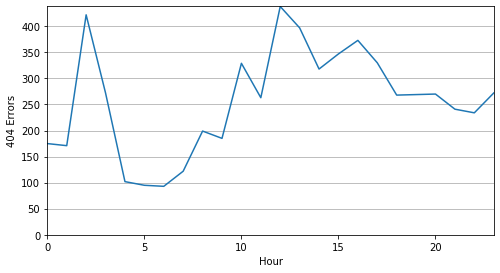

In [43]:
fig = plt.figure(figsize=(8,4.2), facecolor='white', edgecolor='white')
plt.axis([0, max(hoursWithErrors404), 0, max(errors404ByHours)])
plt.grid(b=True, which='major', axis='y')
plt.xlabel('Hour')
plt.ylabel('404 Errors')
plt.plot(hoursWithErrors404, errors404ByHours)
pass